# The Daubechies D4 Wavelet Tranform

##### All functions and variables declaration

In [2]:
from functions import *
import matplotlib.pyplot as plt
from time import time

#### Daubechies coefficients

In [3]:
################## 4 #################
ROOT2, ROOT3 = np.sqrt(2), np.sqrt(3) 

H_COEFFS4 = np.array([(1 + ROOT3) / (4 * ROOT2),(3 + ROOT3) / (4 * ROOT2), (3 - ROOT3) / (4 * ROOT2), (1 - ROOT3) / (4 * ROOT2)])
G_COEFFS4 = np.array([H_COEFFS4[3],-H_COEFFS4[2],H_COEFFS4[1],-H_COEFFS4[0]])


################## 8 #################
H_COEFFS8 = np.array([0.23037781, 0.71484657, 0.63088076, -0.02798376, -0.18703481, 0.03084138, 0.03288301, -0.01059740])
G_COEFFS8 = np.array([-0.01059740, -0.03288301, 0.03084138, 0.18703481, -0.02798376, -0.63088076, 0.71484657, -0.23037781])


##### Checking Orthonormality

In [4]:
h_coeffs, g_coeffs =  H_COEFFS8, G_COEFFS8
verificar_ortonormalidad(h_coeffs, g_coeffs)

The vectors are orthonormal, the dot product is: -8.673617379884035e-19 and the norm of each vector is (0.9999999931242683, 0.9999999931242683) respectively


## NUMERIC EXAMPLE

## IMAGES EXAMPLES

0.10400557518005371


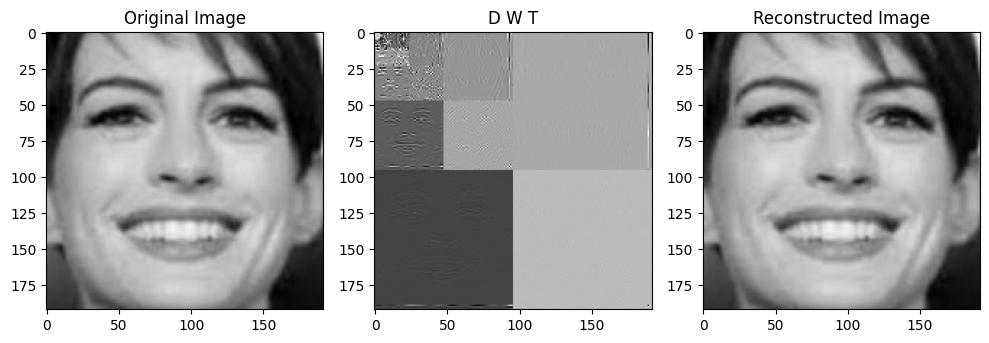

In [11]:
photo = 'images/foto_dataset1.jpg'
array_photo = jpg_to_pgm(photo)

scale = 5 
width = array_photo.shape[0]
daubechies_4 = function_daubechies_coeffs(array_photo, h_coeffs, g_coeffs)


initial_time = time() 

result_img, normalized = daubechies4_wavelet_transform_2D(
    daubechies_4, array_photo, scale, width, h_coeffs, g_coeffs)

# result_img = zeros(result_img, scale)

reconstructed = inverse_daubechies4_wavelet_transform_2D(
    daubechies_4, result_img, scale, width, h_coeffs, g_coeffs)

final_time = time()
print(final_time - initial_time)

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
axes[0].imshow(array_photo, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(normalized, cmap='gray')
axes[1].set_title('D W T')
axes[2].imshow(reconstructed, cmap='gray')
axes[2].set_title('Reconstructed Image')

plt.tight_layout()
plt.show()
# imshow(np.concatenate((array_photo, result_img, reconstructed), axis = 1))